Quickly draw ADC spectrum of a measured source

e.g. from $^{22}$Na, $^{60}$Co or $^{252}Cf$

In [1]:
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/PETsys/Software/analysis/Python'); 
from PETsys_analysis_tools import *;
%config InlineBackend.figure_format = 'retina'

In [66]:
# dT = 1000# sec
# filename = '/Users/erezcohen/Desktop/data/PETsys/Prototype1/Co60_source_1.8uC_24Nov2020/Co60_%dsec_single.dat'%dT;
# dT = 100
# filename = '/Users/erezcohen/Desktop/data/PETsys/Prototype1/Cf252_source_1uC_24Nov2020/Cf252_100sec_single.dat'
dT = 4100
filename = '/Users/erezcohen/Desktop/data/PETsys/Prototype1/Cf252_source_1uC_3Dec2020/Cf252_4100sec_single.dat'

In [67]:
singles = pd.read_csv(filename,delimiter='\t',names=['time','charge','channel'])

In [68]:
channels = np.unique(singles.channel)
print 'detected events in the following channels: ',channels
singles_per_channel = dict()
for ch in channels:
    singles_per_channel[ch] = singles[singles.channel==ch]    
    print 'channel', ch,':',float(len(singles_per_channel[ch]))/dT,'events/sec in sig+bkg'
print 'done grouping'

detected events in the following channels:  [482 533]
channel 482 : 330.992439024 events/sec in sig+bkg
channel 533 : 348.762439024 events/sec in sig+bkg
done grouping


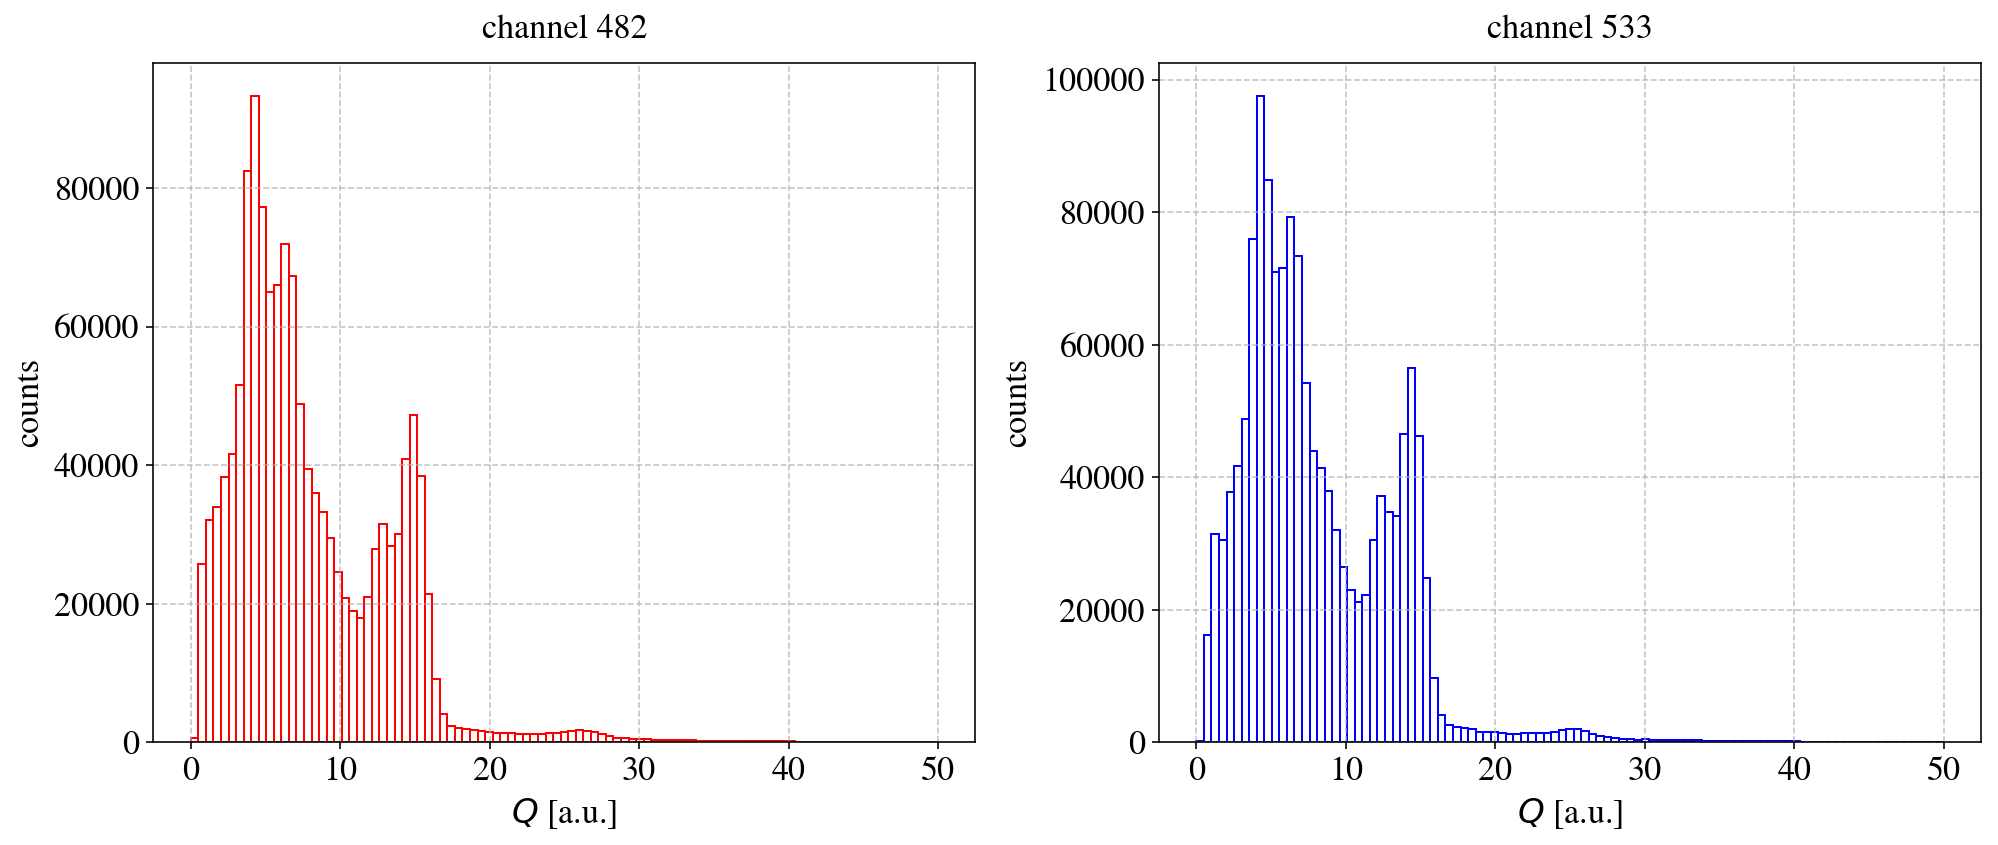

In [69]:
bins = np.linspace(0,50,100)
fig=plt.figure(figsize=(14,6));

for i,ch,color in zip([1,2],channels,['r','b']):
    ax=fig.add_subplot(1,2,i)
    q = lineariseChargeDeposited(singles_per_channel[ch].charge)
    plt.hist(q,bins=bins,label='channel %d'%ch,edgecolor=color,facecolor='None')    
    set_axes(ax=ax,x_label='$Q$ [a.u.]',y_label='counts',title='channel %d'%ch,
         fontsize=17,do_add_grid=True,do_add_legend=False,legend_loc='best');
plt.tight_layout()    

# Calibrate charge to energy using $^{22}$Na source

In [70]:
dT_Na22 = 1000.0 # sec
Na22_singles = pd.read_csv('/Users/erezcohen/Desktop/data/PETsys/Prototype1/Na22_source_0.8uC_3Dec2020/Na22_1000sec_single.dat',delimiter='\t',names=['time','charge','channel'])
dT_Bkg = 100.0 # sec
Bkg_singles = pd.read_csv('/Users/erezcohen/Desktop/data/PETsys/Prototype1/Na22_source_0.8uC_3Dec2020/Background_100sec_single.dat',delimiter='\t',names=['time','charge','channel'])

In [71]:
from scipy.signal import find_peaks

channels = np.unique(Na22_singles.channel)
print 'detected events in the following channels: ',channels
Na22singles,Bkgsingles = dict(),dict()
singlesPerChnnl = dict()
hNa22SigBkg,hBkg,hNa22Sig,hNa22Sig_err = dict(),dict(),dict(),dict()
hSigBkg,hBkg,hSig,hSig_err = dict(),dict(),dict(),dict()
bins=np.linspace(0,58,150); 
x = bins[1:]
# calibrate charge to energy
peaks_Na22sing = dict()
Epoly,x_keV = dict(),dict()


for ch,chIdx in zip(channels,[1,2]):    
    # Na22 signal+background
    Na22singles[ch] = Na22_singles[Na22_singles.channel==ch]    
    hNa22SigBkg[ch],edges = np.histogram(lineariseChargeDeposited(Na22singles[ch].charge),bins=bins);
    # only background
    Bkgsingles[ch] = Bkg_singles[Bkg_singles.channel==ch]    
    hBkg[ch],edges = np.histogram(lineariseChargeDeposited(Bkgsingles[ch].charge),bins=bins);
    # Na22 signal
    hNa22Sig[ch] = np.array(hNa22SigBkg[ch] - hBkg[ch]*(dT_Na22/dT_Bkg))
    hNa22Sig_err[ch] = np.sqrt( np.array(hNa22SigBkg[ch] + hBkg[ch]*(dT_Na22/dT_Bkg)))     
    
    # this measurement signal
    singlesPerChnnl[ch] = singles[singles.channel==ch]    
    hSigBkg[ch],edges = np.histogram(lineariseChargeDeposited(singlesPerChnnl[ch].charge),bins=bins);
    hSig[ch] = np.array(hSigBkg[ch] - hBkg[ch]*(dT/dT_Bkg))
    hSig_err[ch] = np.sqrt( np.array(hSigBkg[ch] + hBkg[ch]*(dT/dT_Bkg)))     

    
    # calibrate using the Na22 source
    peaks_Na22sing[ch],tmp = find_peaks(hNa22Sig[ch][1:-1],prominence=(0.05*np.max(hNa22Sig[ch]), None),distance=30)
    print 'in channel ',ch,',peaks at bins number',peaks_Na22sing[ch]    
    # do not use backscattering at 255.5 keV, 
    # use photo-peak at 511 keV, de-excitation gamma at 1274.5
    peaks2use = peaks_Na22sing[ch][1:];
    Q_au = np.array(x[peaks2use])
    E_keV = np.array([511,1274.5])
    print 'peaks2use:',peaks2use,'Q_au:',Q_au
    popt = np.polyfit( Q_au, E_keV , 1 )
    Epoly[ch] = np.poly1d(popt)
    x_keV[ch] = Epoly[ch](x)
    
# print resulting calibration polynomial parameters
print 'calibration polynomial for channel',channels[0],':',Epoly[channels[0]]
# print 'calibration polynomial for channel',channels[1],':',Epoly[channels[1]]

detected events in the following channels:  [482 533]
in channel  482 ,peaks at bins number [ 15  49 120]
peaks2use: [ 49 120] Q_au: [19.46308725 47.10067114]
in channel  533 ,peaks at bins number [ 15  46 115]
peaks2use: [ 46 115] Q_au: [18.29530201 45.15436242]
calibration polynomial for channel 482 :  
27.63 x - 26.68


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


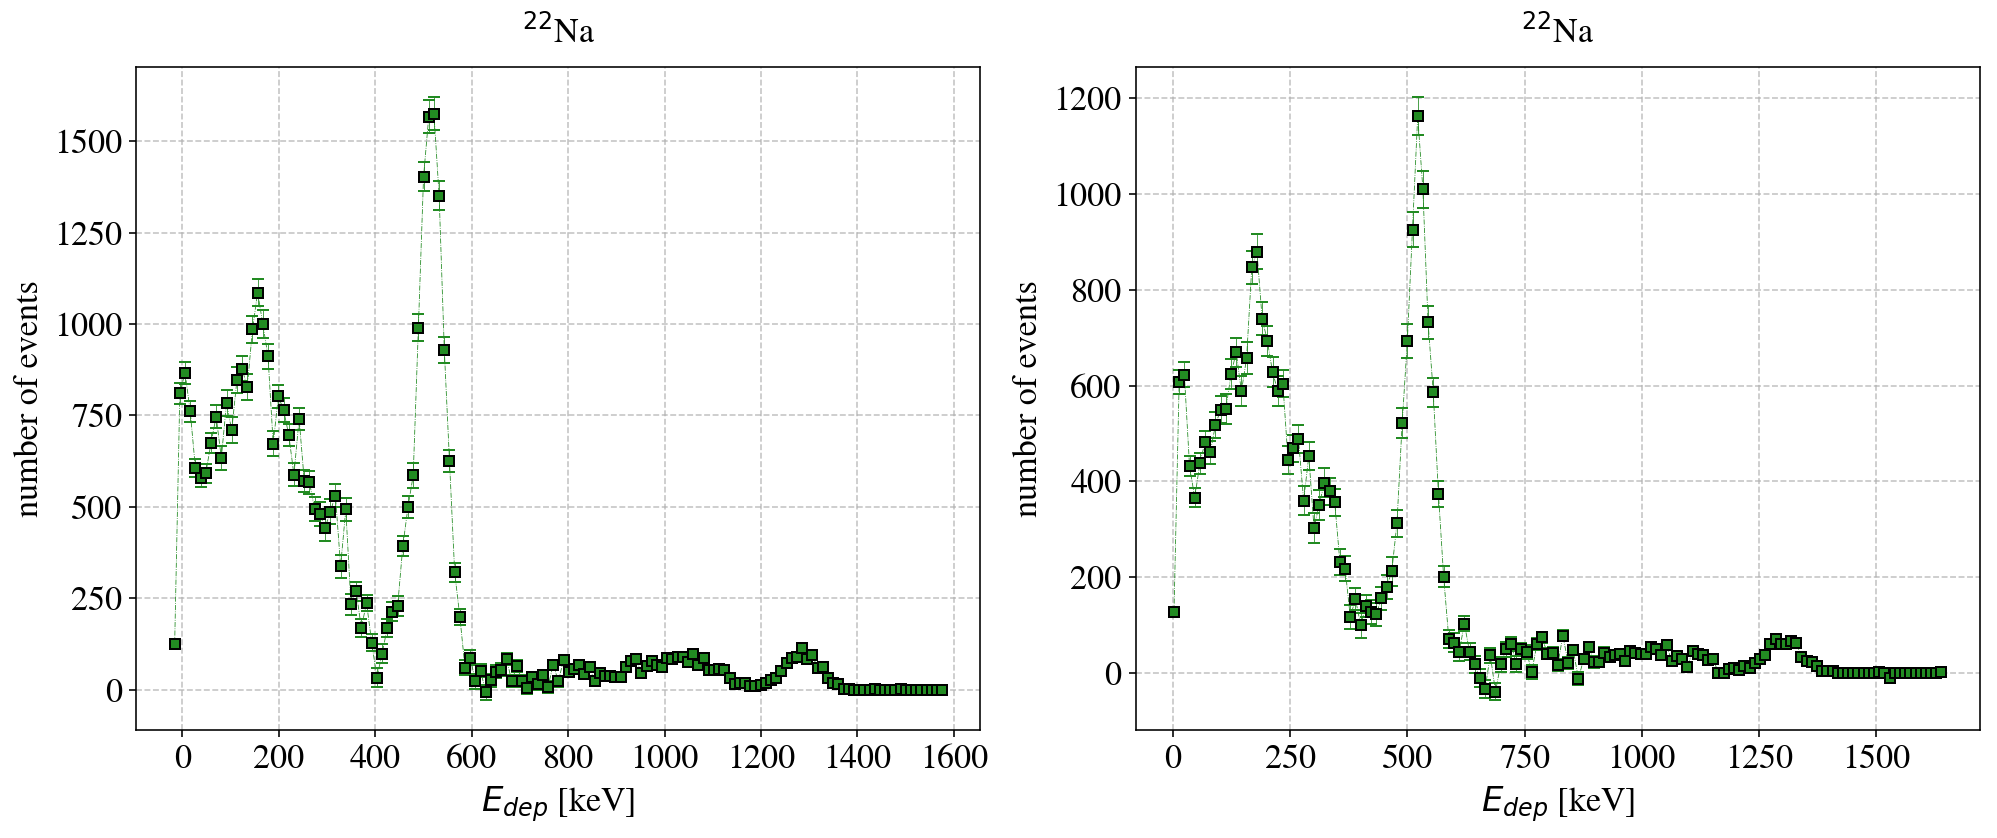

In [72]:
# apply calibration to Na22
for ch,chIdx in zip([channels[0]],[1,2]):    
    # signal+background
    Na22singles[ch]['Energy [keV]'] = Epoly[channels[0]](Na22singles[ch].charge)
fig=plt.figure(figsize=(14,6))
for ch,chIdx in zip(channels,[1,2]):    
    ax=fig.add_subplot(1,2,chIdx)
    plt.errorbar( x_keV[ch], hNa22Sig[ch],  yerr=hNa22Sig_err[ch] ,
                 linewidth=0.4,marker='s',markersize=5,
                 linestyle='-.',color='forestgreen',markeredgecolor='black',
                 capthick=1,capsize=3 );    
    set_axes(ax=ax,x_label='$E_{dep}$ [keV]',y_label='number of events',title='$^{22}$Na',
             fontsize=17,do_add_grid=True,do_add_legend=False,legend_loc='best');
     
plt.tight_layout()

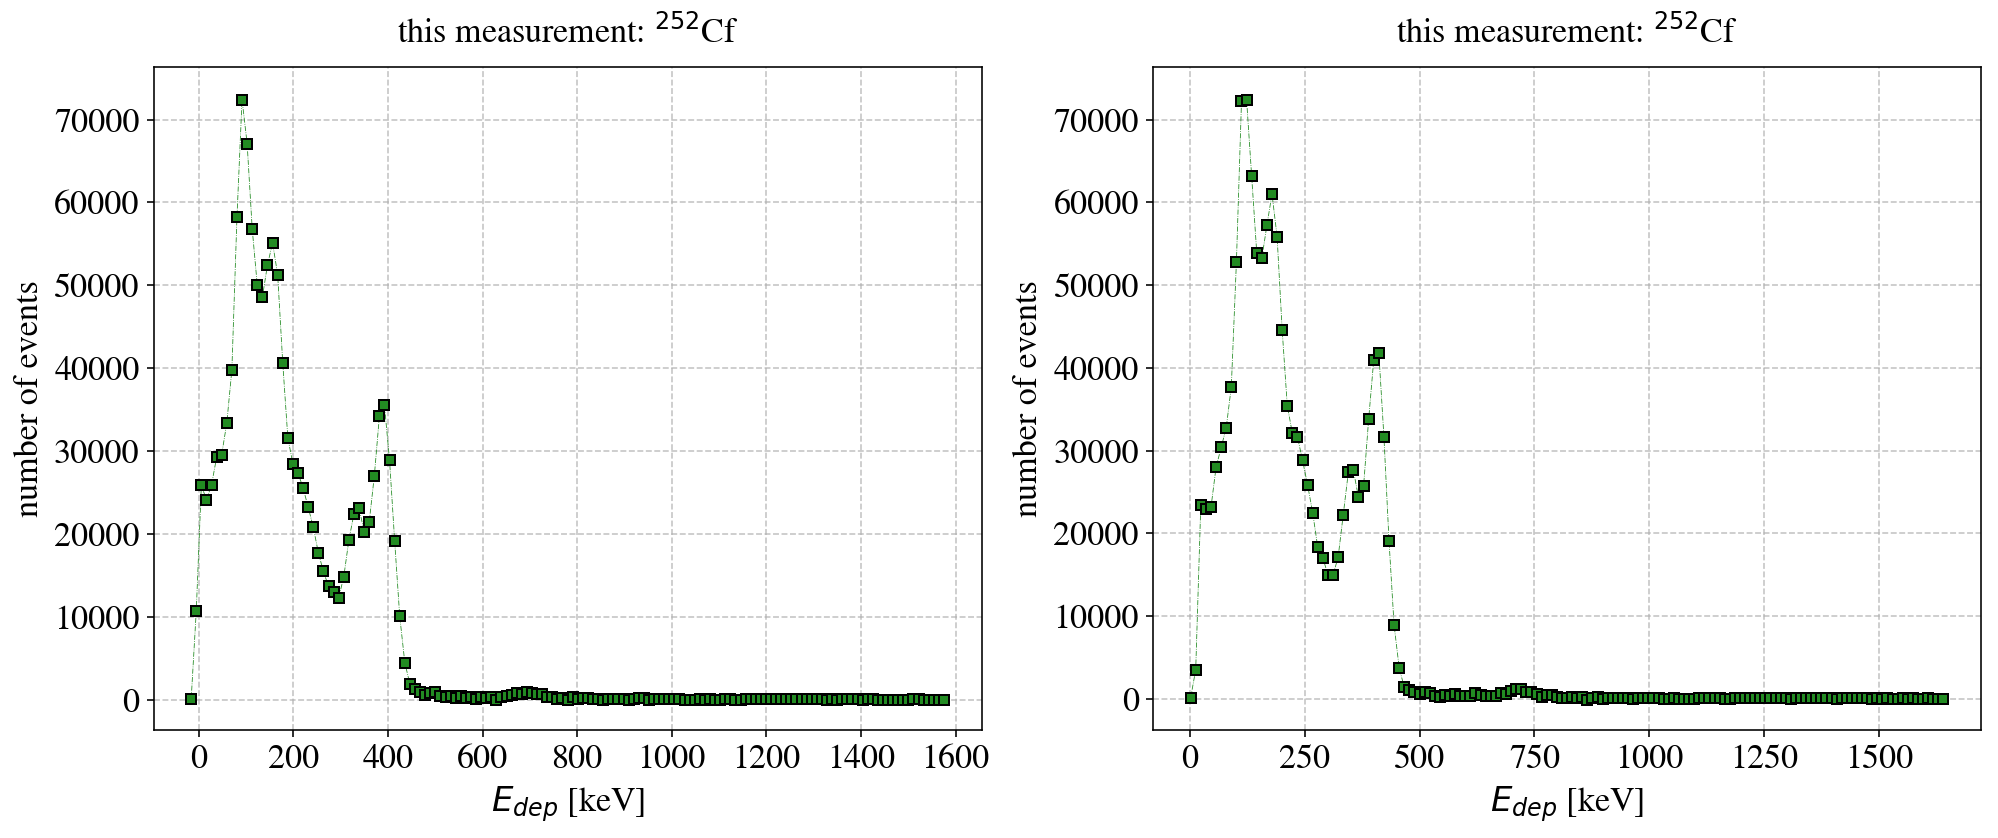

In [73]:
isotope = '$^{252}$Cf'
# apply calibration to measurement
fig=plt.figure(figsize=(14,6))
for ch,chIdx in zip(channels,[1,2]):    
    ax=fig.add_subplot(1,2,chIdx)
    plt.errorbar( x_keV[ch], hSig[ch],  yerr=hSig_err[ch] ,
                 linewidth=0.4,marker='s',markersize=5,
                 linestyle='-.',color='forestgreen',markeredgecolor='black',
                 capthick=1,capsize=3 );    
    set_axes(ax=ax,x_label='$E_{dep}$ [keV]',y_label='number of events',title='this measurement: %s'%isotope,
             fontsize=17,do_add_grid=True,do_add_legend=False,legend_loc='best');
     
plt.tight_layout()

## Nov-24, 2020

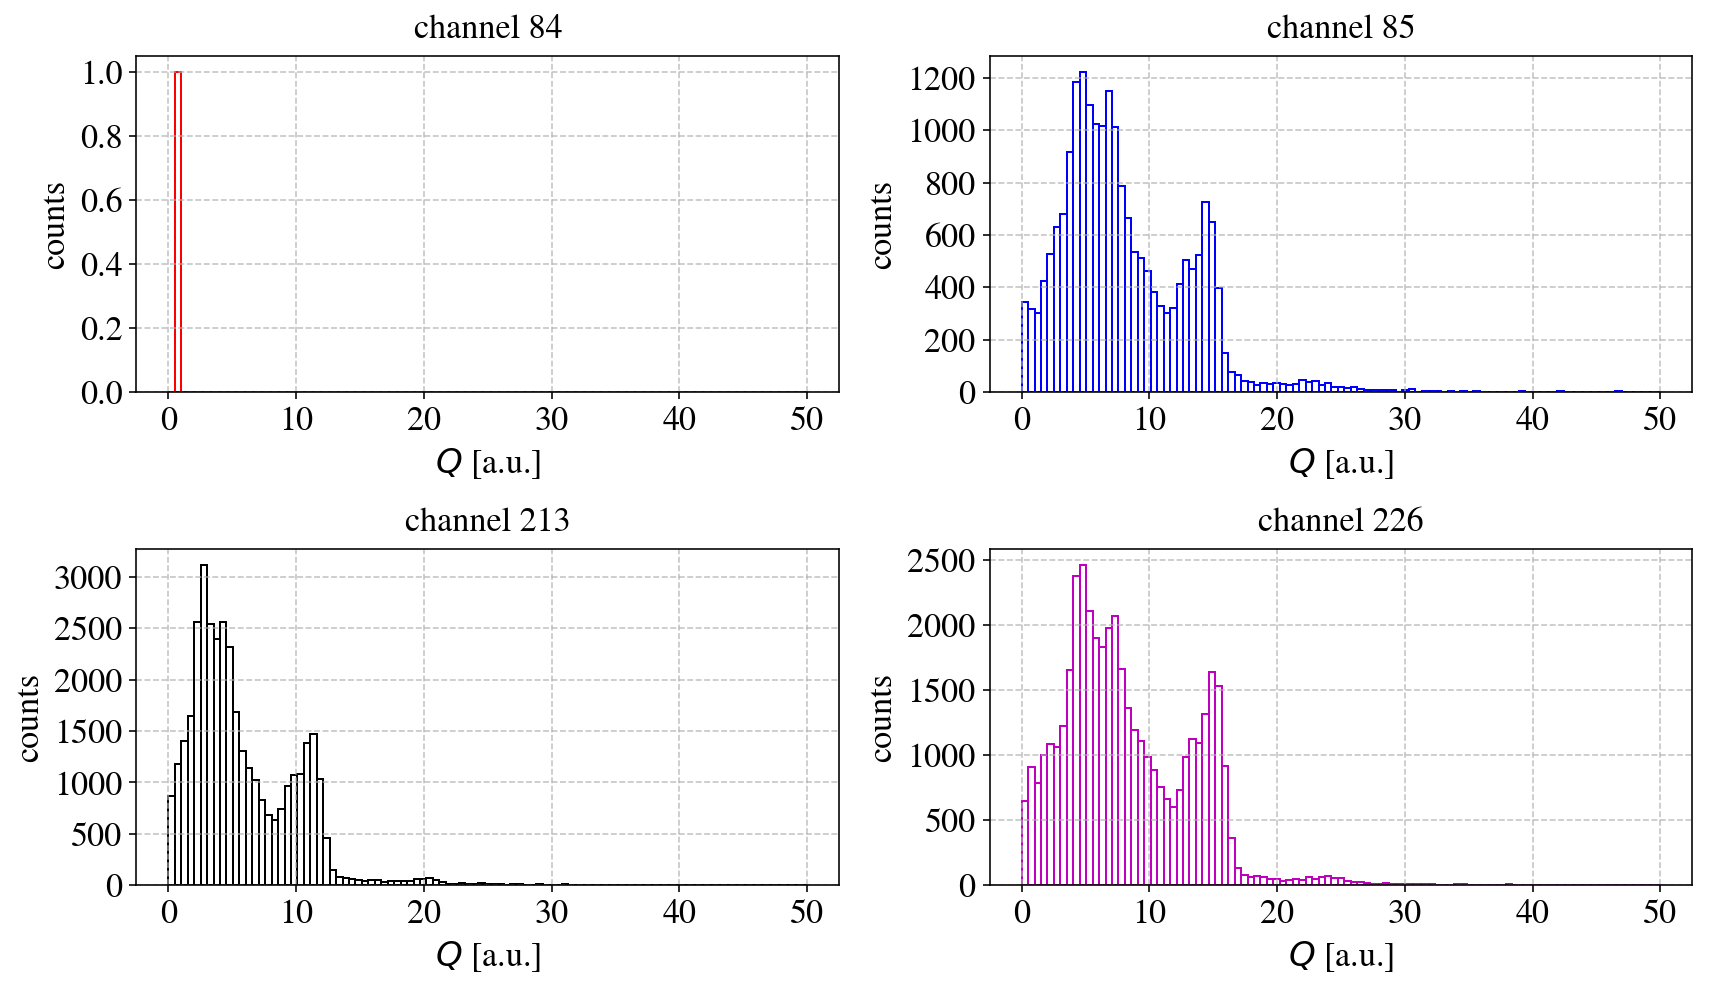

In [44]:
bins = np.linspace(0,50,100)
fig=plt.figure(figsize=(12,7));

for i,ch,color in zip([1,2,3,4],channels,['r','b','k','m']):#162,226,
    ax=fig.add_subplot(2,2,i)
    q = lineariseChargeDeposited(singles_per_channel[ch].charge)
    plt.hist(q,bins=bins,label='channel %d'%ch,edgecolor=color,facecolor='None')    
    set_axes(ax=ax,x_label='$Q$ [a.u.]',y_label='counts',title='channel %d'%ch,
         fontsize=17,do_add_grid=True,do_add_legend=False,legend_loc='best');
plt.tight_layout()    